In [3]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import coherence, hilbert

In [5]:
# ====== CONFIGURACIÓN ======
edf_path = r"C:\Users\V304-17\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf"
sfreq_target = 256            # Frecuencia de muestreo a la que normalizamos (Hz)
fmin, fmax = 8, 13            

In [6]:
# ====== CARGA Y PREPROCESAMIENTO ======
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
data = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

Extracting EDF parameters from C:\Users\V304-17\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\V304-17\AppData\Local\Temp\ipykernel_12536\1692581060.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [7]:
data

array([[-6.26804381e-20,  9.96691423e-05,  1.56464544e-04, ...,
        -3.25461886e-05, -2.44063872e-05, -3.38813179e-21],
       [ 0.00000000e+00,  7.14210275e-05,  1.12391959e-04, ...,
        -5.47231902e-06, -1.78326784e-06, -1.10114283e-20],
       [-8.47032947e-21,  3.00249387e-05,  4.62387169e-05, ...,
         1.76838641e-05,  1.13131737e-05, -8.47032947e-22],
       ...,
       [-5.08219768e-20,  1.84483340e-04,  2.87170890e-04, ...,
         3.62255574e-05,  1.60453355e-05,  5.08219768e-21],
       [-1.10114283e-20, -6.40667792e-05, -1.01071351e-04, ...,
         7.34684870e-06,  1.44976840e-06, -1.27054942e-21],
       [ 1.86347248e-20, -3.08754614e-05, -4.79904833e-05, ...,
        -8.25147645e-06, -5.29050421e-06,  1.16467030e-21]],
      shape=(23, 921600))

In [8]:
ch_names

['FP1-F7',
 'F7-T7',
 'T7-P7',
 'P7-O1',
 'FP1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'FP2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'FP2-F8',
 'F8-T8',
 'T8-P8-0',
 'P8-O2',
 'FZ-CZ',
 'CZ-PZ',
 'P7-T7',
 'T7-FT9',
 'FT9-FT10',
 'FT10-T8',
 'T8-P8-1']

In [10]:
n_channels

23

In [ ]:
#identificar en que casos cada método(3) es adecuado

In [17]:
# ====== 1. MATRIZ DE CORRELACIÓN DE PEARSON ======
corr_matrix = np.corrcoef(data)
corr_df = pd.DataFrame(corr_matrix, index=ch_names, columns=ch_names)
corr_df.to_csv("connectivity_pearson.csv")

# ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(data[i], data[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

coh_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
coh_df.to_csv("connectivity_coherence.csv")

# ====== 3. MATRIZ DE PHASE LOCKING VALUE (PLV) ======
analytic_signal = hilbert(data)
phase_data = np.angle(analytic_signal)

plv_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        phase_diff = phase_data[i] - phase_data[j]
        plv_matrix[i, j] = np.abs(np.sum(np.exp(1j * phase_diff)) / phase_diff.size)

plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)
plv_df.to_csv("connectivity_plv.csv")


In [ ]:
#identificar para que sirven cada uno de los elementos de la función coherence

In [15]:
corr_df, coh_df,plv_df

(            FP1-F7     F7-T7     T7-P7     P7-O1    FP1-F3     F3-C3  \
 FP1-F7    1.000000  0.103592 -0.070391  0.008550  0.792282  0.402987   
 F7-T7     0.103592  1.000000  0.138700  0.005079  0.491057  0.419551   
 T7-P7    -0.070391  0.138700  1.000000  0.149314  0.118458  0.308218   
 P7-O1     0.008550  0.005079  0.149314  1.000000  0.013313  0.063706   
 FP1-F3    0.792282  0.491057  0.118458  0.013313  1.000000  0.302627   
 F3-C3     0.402987  0.419551  0.308218  0.063706  0.302627  1.000000   
 C3-P3     0.221081  0.195553  0.338679  0.383856  0.021996  0.393363   
 P3-O1     0.130110  0.135568  0.291802  0.580096  0.052724 -0.004858   
 FP2-F4    0.744005  0.384312  0.102540  0.044230  0.831614  0.357336   
 F4-C4     0.462771  0.217138  0.161603  0.158999  0.362011  0.526888   
 C4-P4     0.287408  0.090049  0.166814  0.203238  0.128821  0.434965   
 P4-O2     0.153786  0.069655  0.169576  0.488425  0.066738  0.093638   
 FP2-F8    0.736154  0.422422  0.074641  0.061181  

In [18]:
corr_df.head(3)

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
FP1-F7,1.000000,0.103592,-0.070391,0.008550,0.792282,0.402987,0.221081,0.130110,0.744005,0.462771,...,0.487322,0.003882,0.100852,0.437392,0.210561,0.070391,0.282011,-0.246338,-0.040157,0.003882
F7-T7,0.103592,1.000000,0.138700,0.005079,0.491057,0.419551,0.195553,0.135568,0.384312,0.217138,...,0.137333,0.091827,-0.043687,0.309492,0.211246,-0.138700,-0.599087,0.395563,-0.099850,0.091827
T7-P7,-0.070391,0.138700,1.000000,0.149314,0.118458,0.308218,0.338679,0.291802,0.102540,0.161603,...,0.063399,0.326646,0.051256,0.224985,0.272034,-1.000000,0.100195,0.261074,-0.060052,0.326646


In [19]:
corr_df.columns

Index(['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3',
       'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
       'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10',
       'FT10-T8', 'T8-P8-1'],
      dtype='object')

Act. de clase 
Generar el mapa de calor de cada matriz de conectividad 
Generar la distribución de datos de cada matriz
¿Qué valor se encuentra en el percentil 0.75 de c/matriz y compararlos 
Generar el grafo 2d con cada matriz de conect. y compararlos 

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

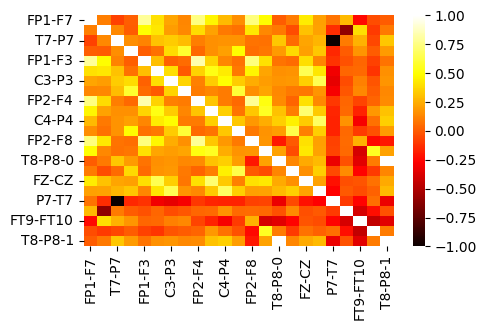

In [22]:
plt.figure(figsize=(5, 3))
sns.heatmap(corr_df, cmap='hot')

<Axes: >

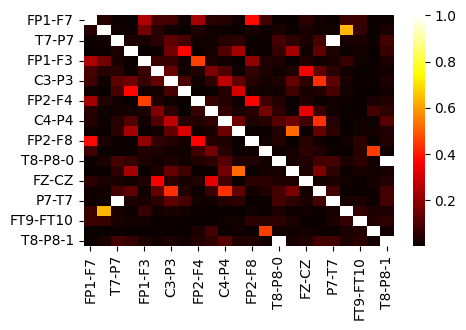

In [23]:
plt.figure(figsize=(5, 3))
sns.heatmap(coh_df, cmap='hot')

<Axes: >

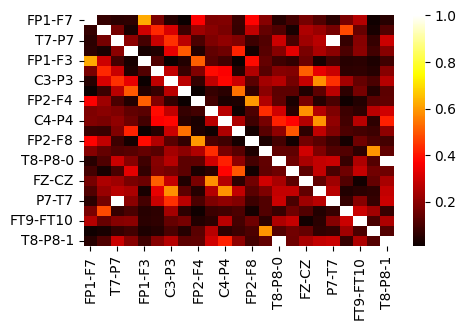

In [24]:
plt.figure(figsize=(5, 3))
sns.heatmap(plv_df, cmap='hot')

(array([  2.,   0.,   4.,  34.,  76., 204., 116.,  46.,  20.,  27.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

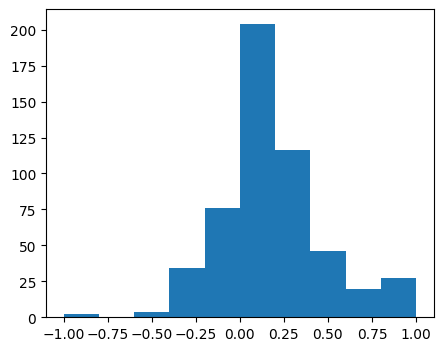

In [31]:
#2
plt.figure(figsize=(5, 4))
plt.hist(corr_df.to_numpy().flatten())

(array([428.,  38.,  12.,  12.,   8.,   2.,   2.,   0.,   0.,  27.]),
 array([0.00104799, 0.10094319, 0.2008384 , 0.3007336 , 0.4006288 ,
        0.500524  , 0.6004192 , 0.7003144 , 0.8002096 , 0.9001048 ,
        1.        ]),
 <BarContainer object of 10 artists>)

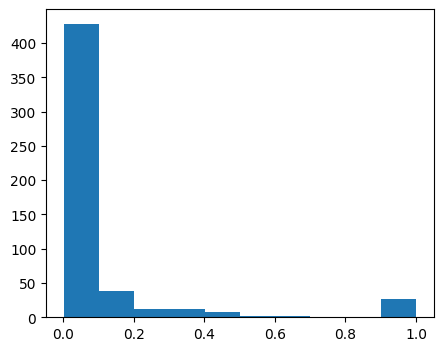

In [32]:
plt.figure(figsize=(5, 4))
plt.hist(coh_df.to_numpy().flatten())

(array([186., 156., 100.,  22.,  20.,  16.,   2.,   0.,   0.,  27.]),
 array([0.00893847, 0.10804462, 0.20715078, 0.30625693, 0.40536308,
        0.50446924, 0.60357539, 0.70268154, 0.80178769, 0.90089385,
        1.        ]),
 <BarContainer object of 10 artists>)

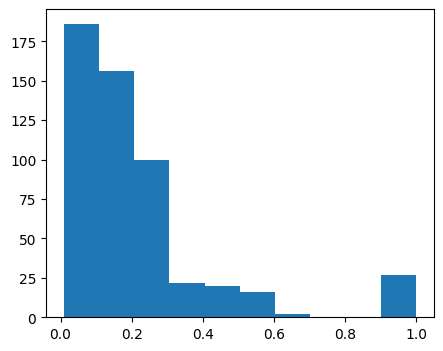

In [33]:
plt.figure(figsize=(5, 4))
plt.hist(plv_df.to_numpy().flatten())

In [ ]:
#3

In [44]:
p75_corr = np.percentile(corr_df.values, 75)
print(p75_corr)

0.32938086580951453


In [45]:
p75_coh = np.percentile(coh_df.values, 75)
print(p75_coh)

0.08287163514424091


In [46]:
p75_plv = np.percentile(plv_df.values, 75)
print(p75_plv)

0.2714964142747309


In [ ]:
#4

In [49]:
import networkx as nx

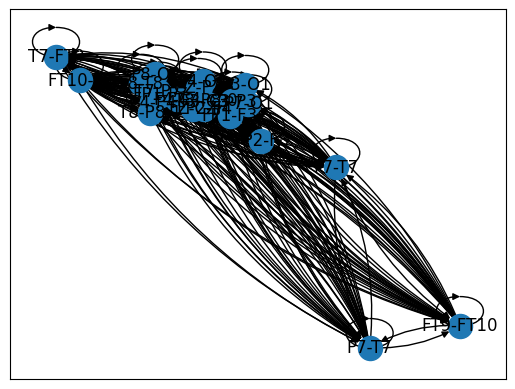

In [57]:
G=nx.from_pandas_adjacency (corr_df, create_using=nx.DiGraph())

pos=nx.spring_layout(G)
nx.draw_networkx(G,with_labels=True, arrows=True, arrowstyle="-|>", connectionstyle ="arc3,rad=0.15")

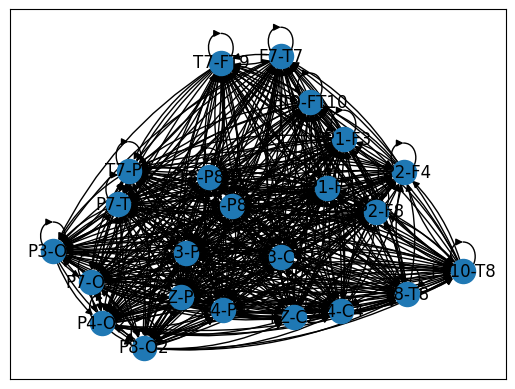

In [58]:
G=nx.from_pandas_adjacency (coh_df, create_using=nx.DiGraph())

pos=nx.spring_layout(G)
nx.draw_networkx(G,with_labels=True, arrows=True, arrowstyle="-|>", connectionstyle ="arc3,rad=0.15")

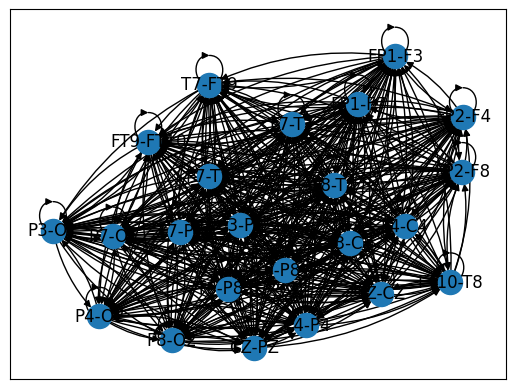

In [59]:
G=nx.from_pandas_adjacency (plv_df, create_using=nx.DiGraph())

pos=nx.spring_layout(G)
nx.draw_networkx(G,with_labels=True, arrows=True, arrowstyle="-|>", connectionstyle ="arc3,rad=0.15")